In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import umap
from lime.lime_text import LimeTextExplainer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    make_scorer,
    f1_score
)
from sentence_transformers import SentenceTransformer
import xgboost as xgb

# Constants and functions

In [3]:
RANDOM_STATE = 2025

In [29]:
def evaluate_classifier(y, y_pred, classes, title):
    report = classification_report(
        y,
        y_pred,
        labels=classes
    )

    print(title, '\n')
    print(report)
    print('\nConfusion matrix:')
    ConfusionMatrixDisplay.from_predictions(
        y,
        y_pred,
        labels=classes,
        normalize='true',
        xticks_rotation='vertical'
    )
    

def get_class_indices(y, classes):
    class_to_index = {label: i for i, label in enumerate(classes)}
    return [class_to_index[label] for label in y]


def get_local_feature_contributions(y_pred, classes, X_tfidf, coef, feature_names, top_n):
    pred_class_idx = get_class_indices(y_pred, classes)
    
    tfidf = X_tfidf
    weights = coef[pred_class_idx]
    contribs = tfidf * weights
    
    idx_topn = np.argsort(np.abs(contribs), axis=1)[:, -top_n:]
    top_features = feature_names[idx_topn]
    top_contribs = np.take_along_axis(contribs, idx_topn, axis=1)
    
    return top_features, top_contribs


def get_rank_and_probs(y_pred_prob, y_true, y_pred, classes):
    prob_df = pd.DataFrame(y_pred_prob, columns=classes)
    rank_df = prob_df.rank(ascending=False, axis=1).astype('int')
    rank_true = [rank_df.loc[i, true] for i, true in enumerate(y_true)]
    prob_true = [prob_df.loc[i, true] for i, true in enumerate(y_true)]
    prob_pred = [prob_df.loc[i, pred] for i, pred in enumerate(y_pred)]
    return rank_true, prob_true, prob_pred


def build_error_df(
    X_val,
    y_val,
    y_val_pred,
    rank_true,
    prob_true,
    prob_pred,
    top_features,
    top_features_contrib
):
    error_df = (
        pd.DataFrame({
            'text': X_val,
            'true': y_val,
            'predicted': y_val_pred
        })[errors]
        .assign(
            rank_true=rank_true,
            prob_true=prob_true,
            prob_pred=prob_pred,
            top_features=top_features,
            top_features_contrib=top_features_contrib
        )
        .reset_index(drop=True)
    )
    
    error_df = error_df.sort_values(['true', 'predicted']).round(3)
    return error_df


def correct_vs_incorrect(pred_prob, pred, actual):
    errors = pred != actual
    max_probs = np.max(pred_prob, axis=1)
    sns.kdeplot(max_probs[~errors], label='Correct', fill=True)
    sns.kdeplot(max_probs[errors], label='Incorrect', fill=True)
    plt.xlabel("Max predicted probability (confidence)")
    plt.title("Model confidence: Correct vs. Incorrect predictions")
    plt.legend()
    plt.tight_layout()


def plot_embeddings_with_errors(embeddings, true_labels, pred_labels):
    le = LabelEncoder()
    y_true_enc = le.fit_transform(true_labels)
    y_pred_enc = le.transform(pred_labels)

    misclassified = y_true_enc != y_pred_enc
    reducer = umap.UMAP(random_state=42)
    reduced = reducer.fit_transform(embeddings)

    colors = plt.cm.Set1(np.linspace(0, 1, len(le.classes_)))
    fig, ax = plt.subplots(figsize=(10, 8))

    for i, label in enumerate(le.classes_):
        is_class = y_true_enc == i
        ax.scatter(*reduced[is_class & ~misclassified].T, 
                   c=[colors[i]], s=30, alpha=0.6, label=f'{label}')
        ax.scatter(*reduced[is_class & misclassified].T, 
                   c=[colors[i]], s=80, alpha=1.0, edgecolors='black', linewidth=1.5, 
                   label=f'{label} incorrect')

    ax.set_title("UMAP: Validation Embeddings with Misclassifications")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


def lime_local_explanations(predict_proba_fn, classes, X, n_samples):
    explainer = LimeTextExplainer(class_names=classes)
    features = []
    contribs = []
    for text in X:
        explanation = explainer.explain_instance(
            text,
            predict_proba,
            num_samples=n_samples,
            num_features=5
        )
        exp_sorted = sorted(explanation.as_list(), key=lambda x: x[1])
        words = [str(item[0]) for item in exp_sorted]
        scores = [round(float(item[1]), 3) for item in exp_sorted]
        exp_sorted = np.sort(np.array(explanation.as_list()), axis=0)
        features.append(words)
        contribs.append(scores)
    return features, contribs

# Load  and split data

In [5]:
df = (
    pd.read_csv("../../artifacts/data/bbc-text.csv")
    .drop_duplicates()
    .reset_index(drop=True)
)

In [6]:
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2121,business,cars pull down us retail figures us retail sal...
2122,politics,kilroy unveils immigration policy ex-chatshow ...
2123,entertainment,rem announce new glasgow concert us band rem h...
2124,politics,how political squabbles snowball it s become c...


In [7]:
classes = df.category.unique()

In [8]:
def reset_pair(X, y):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    return X, y


X = df.text
y = df.category

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.30,
    random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    stratify=y_temp,
    test_size=0.5,
    random_state=RANDOM_STATE
)

X_train, y_train = reset_pair(X_train, y_train)
X_val, y_val = reset_pair(X_val, y_val)
X_test, y_test = reset_pair(X_test, y_test)

# Model 1: TDIDF + Logistic regression

This is a simple, classic method for text classification and should act as a strong baseline to compare against more complex approaches.

## Feature extraction

In [9]:
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=1000,
    # can tune these later if time:
    # min_df=2,           # Ignore words appearing in <2 documents
    # max_df=0.95,        # Ignore words appearing in >95% of documents
    # lowercase=True,     # Normalize case
    token_pattern=r'\b[a-zA-Z]{2,}\b',  # Only alphabetic words, 2+ chars
    # ngram_range=(1, 3)
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

feature_names = vectorizer.get_feature_names_out()

## Model training

In [10]:
model1 = LogisticRegression(max_iter=1000)
model1.fit(X_train_tfidf, y_train)
y_train_pred = model1.predict(X_train_tfidf)
y_val_pred = model1.predict(X_val_tfidf)
y_val_pred_prob = model1.predict_proba(X_val_tfidf)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


## Evaluation

### Train

Per the below, the model performs extremely well on the training set:

TRAIN 

               precision    recall  f1-score   support

     business       0.99      0.99      0.99       352
entertainment       1.00      1.00      1.00       258
     politics       0.99      0.99      0.99       282
        sport       1.00      1.00      1.00       353
         tech       0.99      0.99      0.99       243

     accuracy                           0.99      1488
    macro avg       0.99      0.99      0.99      1488
 weighted avg       0.99      0.99      0.99      1488


Confusion matrix:


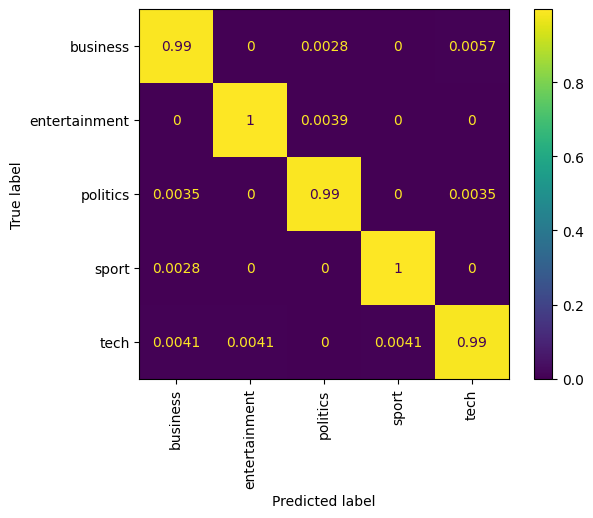

In [11]:
evaluate_classifier(y_train, y_train_pred, model1.classes_, 'TRAIN')

### Val

The model also performs very well on the validation set. Sport is perfectly classified but some errors are made on the other classes:
- Tech is sometimes confused for entertainment or business.
- Business and politics are sometimes confused for one another.

VAL 

               precision    recall  f1-score   support

     business       0.95      0.93      0.94        76
entertainment       0.98      0.95      0.96        56
     politics       0.92      0.95      0.93        60
        sport       1.00      1.00      1.00        75
         tech       0.94      0.96      0.95        52

     accuracy                           0.96       319
    macro avg       0.96      0.96      0.96       319
 weighted avg       0.96      0.96      0.96       319


Confusion matrix:


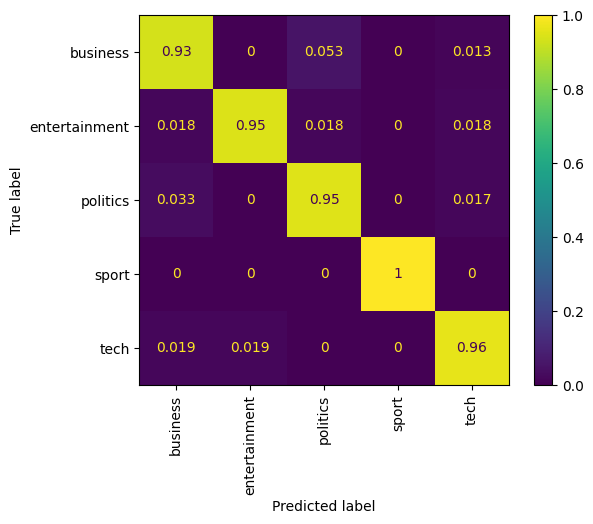

In [12]:
evaluate_classifier(y_val, y_val_pred, model1.classes_, 'VAL')

### Feature importance

<Axes: ylabel='word'>

Text(0, 0.5, '')

(-3.5, 3.5)

Text(0.5, 1.0, 'business')

<Axes: ylabel='word'>

Text(0, 0.5, '')

(-3.5, 3.5)

Text(0.5, 1.0, 'entertainment')

<Axes: ylabel='word'>

Text(0, 0.5, '')

(-3.5, 3.5)

Text(0.5, 1.0, 'politics')

<Axes: ylabel='word'>

Text(0, 0.5, '')

(-3.5, 3.5)

Text(0.5, 1.0, 'sport')

<Axes: ylabel='word'>

Text(0, 0.5, '')

(-3.5, 3.5)

Text(0.5, 1.0, 'tech')

Text(0.5, 0.98, 'TOP AND BOTTOM 10 FEATURES BY CATEGORY')

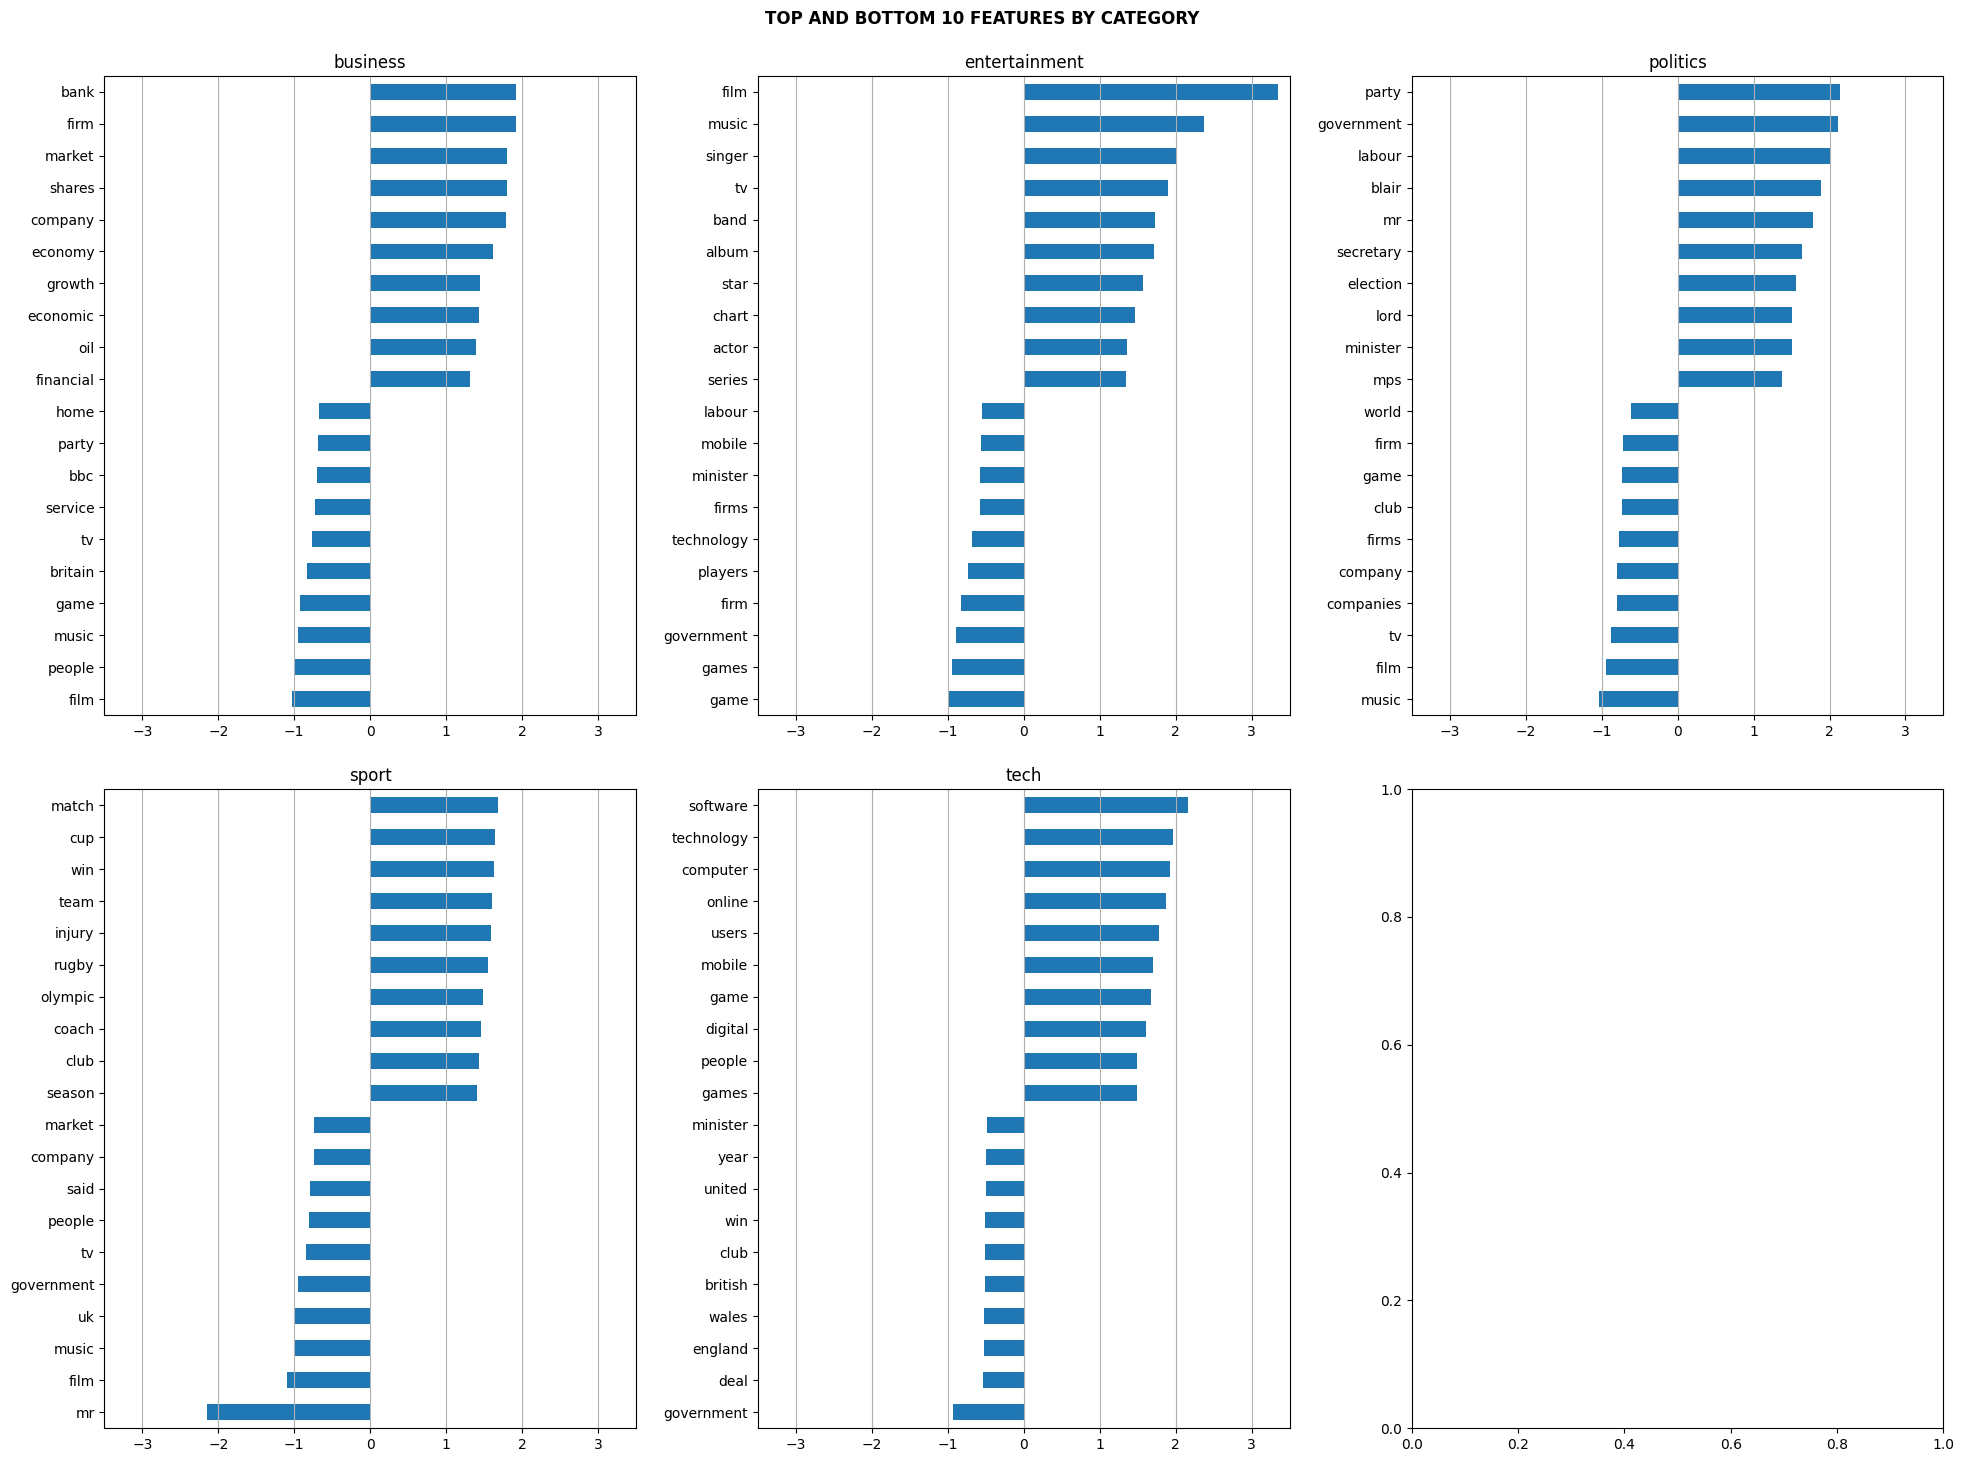

In [13]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20,15))

for i, class_label in enumerate(model1.classes_):
    row, col = np.divmod(i, 3)
    importance_df = (
        pd.DataFrame({
            'word': feature_names,
            'weight': model1.coef_[i]
        })
        .set_index('word')
        .sort_values('weight', ascending=False)
    )
    (
        pd.concat([importance_df.head(10), importance_df.tail(10)])
        .sort_values('weight')
        .plot(kind='barh', ax=ax[row, col])
    )
    ax[row, col].set_ylabel('')
    ax[row, col].set_xlim(-3.5, 3.5)
    ax[row, col].legend().set_visible(False)
    ax[row, col].set_title(class_label)
    ax[row, col].grid(axis='x')
plt.suptitle("TOP AND BOTTOM 10 FEATURES BY CATEGORY", weight="bold")
plt.tight_layout(pad=2)

### Error analysis

The model is much less confident when the prediction is wrong which is a good sign:

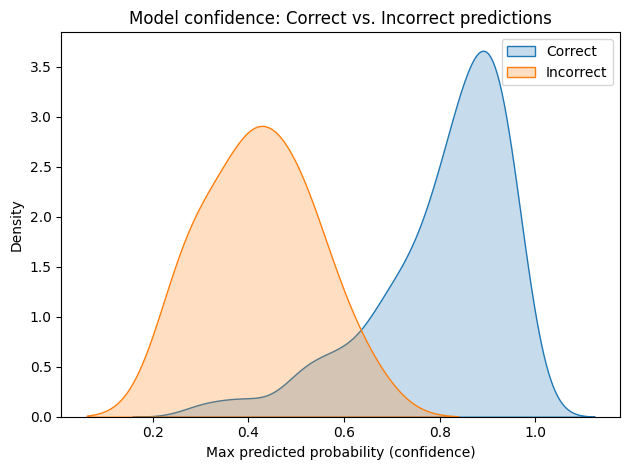

In [14]:
correct_vs_incorrect(y_val_pred_prob, y_val_pred, y_val)

In [15]:
errors = y_val != y_val_pred
classes = model1.classes_
coef = model1.coef_

top_features, top_contribs = get_local_feature_contributions(
    y_val_pred[errors],
    classes,
    X_val_tfidf.toarray()[errors],
    coef,
    feature_names,
    top_n=5,
)

rank_true, prob_true, prob_pred = get_rank_and_probs(
    y_val_pred_prob[errors],
    y_val[errors],
    y_val_pred[errors],
    classes
)

error_df = build_error_df(
    X_val[errors],
    y_val[errors],
    y_val_pred[errors],
    rank_true,
    prob_true,
    prob_pred,
    top_features.tolist(),
    top_contribs.round(2).tolist()
)

/var/folders/f0/lg0qyy8n1gg_khp86kzryb8h0000gn/T/ipykernel_43256/1068199656.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.DataFrame({


Comments:
- The true class is usually the 2nd choice but sometimes 3rd or even 4th ranked.
- Business is sometimes misclassified as politics due to strong word overlap e.g. government, minister, labour.
- The same can be said for other misclassified examples e.g. words like 'awards' for tech and entertainment.

Hence, the model struggles where the topic boundaries are unclear when looking at single words alone. Recommendations:
- Use bigram features.
- Use a proper embedding model to proper represent semantics of the sentence e.g. SentenceTransformers.

In [16]:
error_df

,text,true,predicted,rank_true,prob_true,prob_pred,top_features,top_features_contrib
1,rich grab half colombia poor fund half of the ...,business,politics,2,0.370,0.482,"[education, mr, health, said, government]","[0.09, 0.1, 0.1, 0.14, 0.89]"
2,salary scandal in cameroon cameroon says wides...,business,politics,2,0.233,0.635,"[office, said, prime, government, minister]","[0.18, 0.2, 0.3, 0.42, 0.46]"
11,saudi ministry to employ women women will be e...,business,politics,3,0.184,0.407,"[foreign, government, labour, minister, women]","[0.09, 0.11, 0.14, 0.19, 0.38]"
12,golden rule boost for chancellor chancellor go...,business,politics,2,0.329,0.540,"[government, said, chancellor, mr, brown]","[0.21, 0.22, 0.23, 0.28, 0.4]"
9,cash gives way to flexible friend spending on ...,business,tech,2,0.241,0.265,"[customers, uk, way, cash, cards]","[0.06, 0.07, 0.09, 0.15, 0.17]"
3,uk s national gallery in the pink the national...,entertainment,business,3,0.185,0.410,"[uk, rose, rise, growth, figures]","[-0.08, 0.09, 0.09, 0.11, 0.21]"
7,uganda bans vagina monologues uganda s authori...,entertainment,politics,4,0.111,0.389,"[said, government, play, council, women]","[0.11, 0.11, -0.16, 0.26, 0.29]"
5,stern dropped from radio stations controversia...,entertainment,tech,2,0.244,0.268,"[popular, network, radio, service, media]","[0.06, 0.15, 0.16, 0.23, 0.23]"
0,nuclear strike key terror risk the uk and us...,politics,business,2,0.251,0.286,"[states, says, president, state, russia]","[0.05, -0.05, 0.07, 0.08, 0.15]"
10,eu fraud clampdown urged eu member states are ...,politics,business,2,0.250,0.496,"[reported, euros, state, financial, fraud]","[0.04, 0.04, 0.06, 0.08, 0.69]"


# Model 2: Sentence transformers + Logistic regression

## Feature extraction

In [17]:
encoder = SentenceTransformer("all-MiniLM-L6-v2", device='cpu')
X_train_embed = encoder.encode(X_train)
X_val_embed = encoder.encode(X_val)

## Train

In [18]:
model2 = LogisticRegression(max_iter=1000)
model2.fit(X_train_embed, y_train)
y_train_pred = model2.predict(X_train_embed)
y_val_pred = model2.predict(X_val_embed)
y_val_pred_prob = model2.predict_proba(X_val_embed)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


## Evaluate

### Train

TRAIN 

               precision    recall  f1-score   support

     business       0.99      0.97      0.98       352
entertainment       0.99      0.99      0.99       258
     politics       0.98      0.98      0.98       282
        sport       0.99      1.00      0.99       353
         tech       0.97      0.98      0.98       243

     accuracy                           0.98      1488
    macro avg       0.98      0.98      0.98      1488
 weighted avg       0.98      0.98      0.98      1488


Confusion matrix:


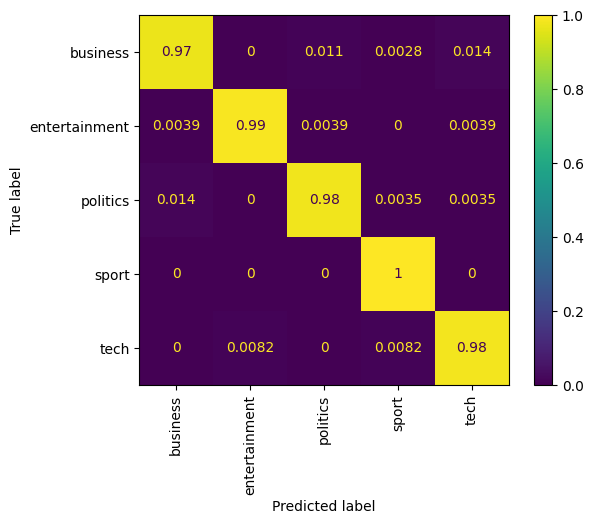

In [19]:
evaluate_classifier(y_train, y_train_pred, model2.classes_, 'TRAIN')

### Val

VAL 

               precision    recall  f1-score   support

     business       0.99      0.99      0.99        76
entertainment       1.00      1.00      1.00        56
     politics       0.95      0.95      0.95        60
        sport       0.99      0.99      0.99        75
         tech       0.96      0.96      0.96        52

     accuracy                           0.98       319
    macro avg       0.98      0.98      0.98       319
 weighted avg       0.98      0.98      0.98       319


Confusion matrix:


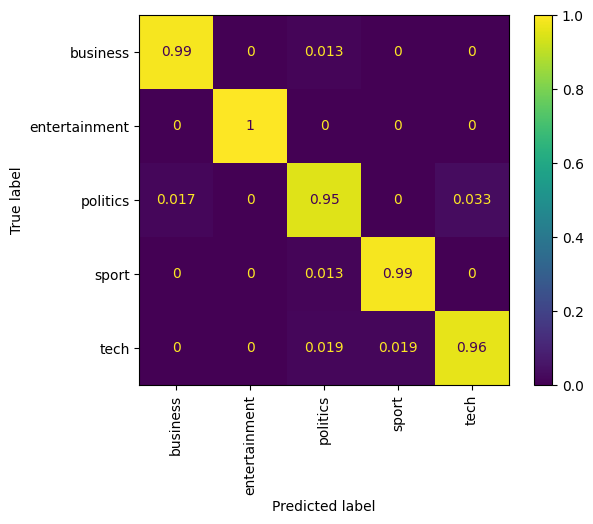

In [20]:
evaluate_classifier(y_val, y_val_pred, model2.classes_, 'VAL')

### Error analysis

The model is much less confident when the prediction is wrong which is a good sign:

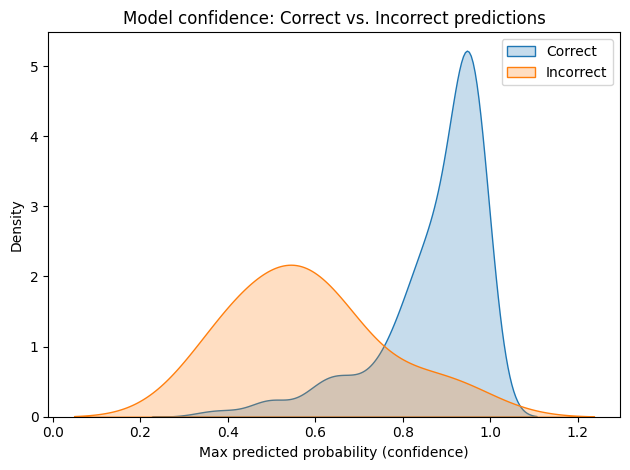

In [21]:
correct_vs_incorrect(y_val_pred_prob, y_val_pred, y_val)

In [30]:
errors = y_val != y_val_pred
classes = model2.classes_
coef = model2.coef_

def predict_proba(texts):
    embeddings = encoder.encode(texts)
    return model2.predict_proba(embeddings)
features, contribs = lime_local_explanations(
    predict_proba,
    classes,
    X_val[errors],
    n_samples=100
)

rank_true, prob_true, prob_pred = get_rank_and_probs(
    y_val_pred_prob[errors],
    y_val[errors],
    y_val_pred[errors],
    classes
)

error_df = build_error_df(
    X_val[errors],
    y_val[errors],
    y_val_pred[errors],
    rank_true,
    prob_true,
    prob_pred,
    features,
    contribs
)
error_df

/var/folders/f0/lg0qyy8n1gg_khp86kzryb8h0000gn/T/ipykernel_43256/246135919.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.DataFrame({


,text,true,predicted,rank_true,prob_true,prob_pred,top_features,top_features_contrib
6,golden rule boost for chancellor chancellor go...,business,politics,2,0.391,0.556,"[mr, ended, brown, area, figures]","[-0.006, -0.006, -0.005, -0.004, 0.005]"
5,eu fraud clampdown urged eu member states are ...,politics,business,2,0.196,0.670,"[clampdown, doing, reporting, irregularities, ...","[-0.012, -0.007, 0.005, 0.006, 0.012]"
0,us casino tricks face ban in uk controversia...,politics,tech,2,0.258,0.408,"[tactic, is, level, tricks, unawares]","[-0.019, -0.014, -0.011, 0.014, 0.015]"
1,uk firms embracing e-commerce uk firms are e...,politics,tech,3,0.045,0.892,"[broadband, third, ict, commerce, were]","[-0.004, -0.004, -0.003, -0.003, -0.002]"
4,campbell to be lions consultant former governm...,sport,politics,2,0.331,0.542,"[head, processes, springs, tony, tour]","[-0.051, -0.033, -0.032, -0.025, 0.088]"
3,online commons to spark debate online communit...,tech,politics,2,0.381,0.597,"[go, foster, they, uk, the]","[-0.006, -0.005, -0.004, -0.003, 0.003]"
2,humanoid robot learns how to run car-maker hon...,tech,sport,2,0.267,0.393,"[leap, state, advances, audience, how]","[-0.029, -0.028, -0.023, 0.016, 0.024]"


/Users/alex/Documents/bbc-news-challenge/bbc-env-311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alex/Documents/bbc-news-challenge/bbc-env-311/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


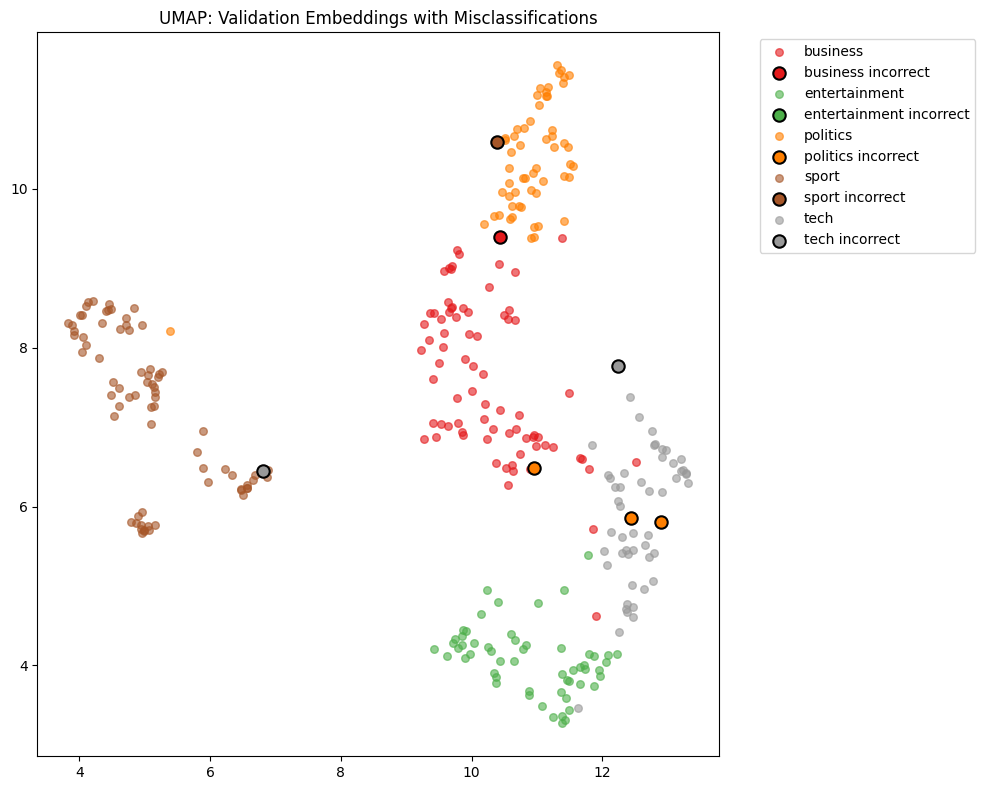

In [31]:
plot_embeddings_with_errors(X_val_embed, y_val, y_val_pred)

# Model 3: Sentence transformers + XGBoost

## Preprocessing

In [32]:
# Create encoder and fit on full label set
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

## Feature extraction

In [33]:
encoder = SentenceTransformer("all-MiniLM-L6-v2", device='cpu')
X_train_embed = encoder.encode(X_train)
X_val_embed = encoder.encode(X_val)

## Train

In [34]:
xgb_model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=len(classes),
    eval_metric="mlogloss",
    random_state=RANDOM_STATE,
)

In [35]:
# hyperparameter tuning

param_grid = {
    'max_depth': [1, 2, 3, 4],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 300, 500, 1000],
    'subsample': [0.6, 0.8, 1.0],
    'reg_alpha': [1, 10, 100],
    'reg_lambda': [1, 10, 100]
}


f1_macro = make_scorer(f1_score, average='macro')
grid_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    scoring=f1_macro,
    cv=3,
    n_iter=100,
    verbose=4,
    n_jobs=-1
)

grid_search.fit(X_train_embed, y_train_encoded)

model3 = grid_search.best_estimator_
print("Best params:", grid_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


,estimator,"XGBClassifier..._class=5, ...)"
,param_distributions,"{'learning_rate': [0.01, 0.1], 'max_depth': [1, 2, ...], 'n_estimators': [100, 300, ...], 'reg_alpha': [1, 10, ...], ...}"
,n_iter,100
,scoring,make_scorer(f...average=macro)
,n_jobs,-1
,refit,True
,cv,3
,verbose,4
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


Best params: {'subsample': 0.6, 'reg_lambda': 100, 'reg_alpha': 1, 'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.1}


In [36]:
y_train_pred = model3.predict(X_train_embed)
y_train_pred = pd.Series(label_encoder.inverse_transform(y_train_pred))

y_val_pred = model3.predict(X_val_embed)
y_val_pred = pd.Series(label_encoder.inverse_transform(y_val_pred))
y_val_pred_prob = model3.predict_proba(X_val_embed)

## Evaluate

In [37]:
classes = label_encoder.inverse_transform(model3.classes_)

TRAIN 

               precision    recall  f1-score   support

     business       1.00      1.00      1.00       352
entertainment       1.00      1.00      1.00       258
     politics       1.00      1.00      1.00       282
        sport       1.00      1.00      1.00       353
         tech       1.00      1.00      1.00       243

     accuracy                           1.00      1488
    macro avg       1.00      1.00      1.00      1488
 weighted avg       1.00      1.00      1.00      1488


Confusion matrix:


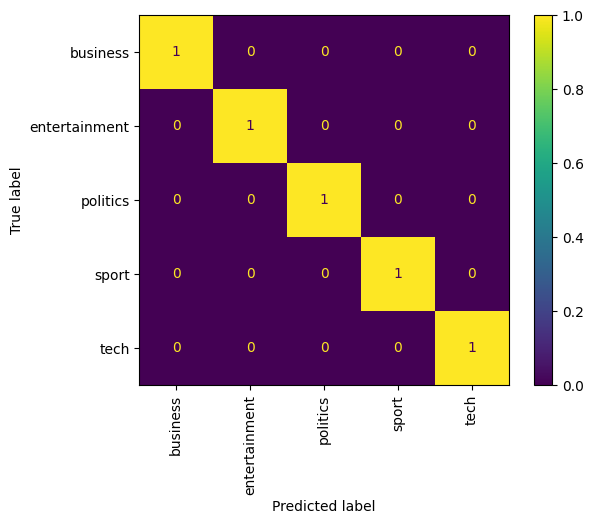

In [38]:
evaluate_classifier(y_train, y_train_pred, classes, 'TRAIN')

VAL 

               precision    recall  f1-score   support

     business       0.99      0.93      0.96        76
entertainment       0.95      0.96      0.96        56
     politics       0.93      0.95      0.94        60
        sport       0.99      0.99      0.99        75
         tech       0.91      0.94      0.92        52

     accuracy                           0.96       319
    macro avg       0.95      0.96      0.95       319
 weighted avg       0.96      0.96      0.96       319


Confusion matrix:


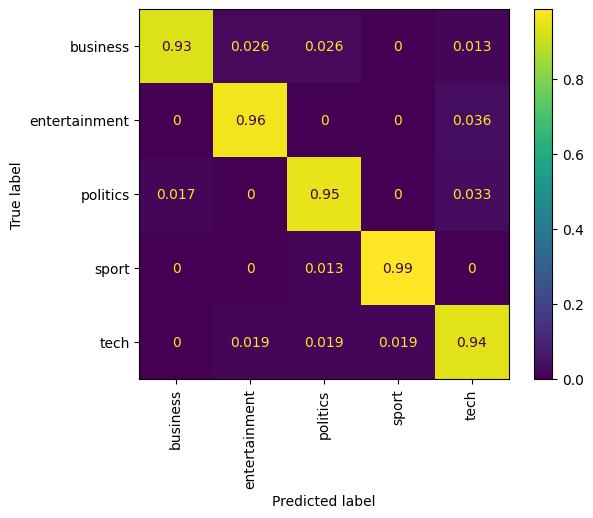

In [39]:
evaluate_classifier(y_val, y_val_pred, classes, 'VAL')

## Error analysis

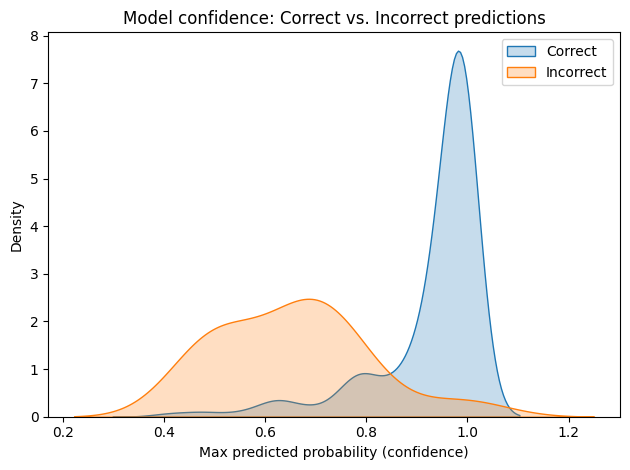

In [40]:
correct_vs_incorrect(y_val_pred_prob, y_val_pred, y_val)

# Final evaluation

Model 2 is chosen as it's performance is the best and it's simpler than model 3 (XGBoost). The only downside is the lack of interpretability given the text embeddings are not human interpretable.

In [41]:
# evaluate on test set

X_test_embed = encoder.encode(X_test)
y_test_pred = model2.predict(X_test_embed)
y_test_pred_prob = model2.predict_proba(X_test_embed)

TEST 

               precision    recall  f1-score   support

     business       0.97      0.93      0.95        75
entertainment       0.98      1.00      0.99        55
     politics       0.95      0.97      0.96        61
        sport       0.97      1.00      0.99        76
         tech       0.96      0.94      0.95        52

     accuracy                           0.97       319
    macro avg       0.97      0.97      0.97       319
 weighted avg       0.97      0.97      0.97       319


Confusion matrix:


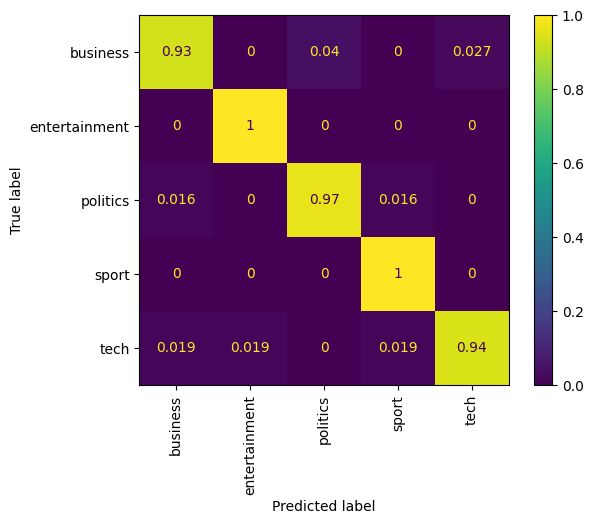

In [42]:
evaluate_classifier(y_test, y_test_pred, model2.classes_, 'TEST')

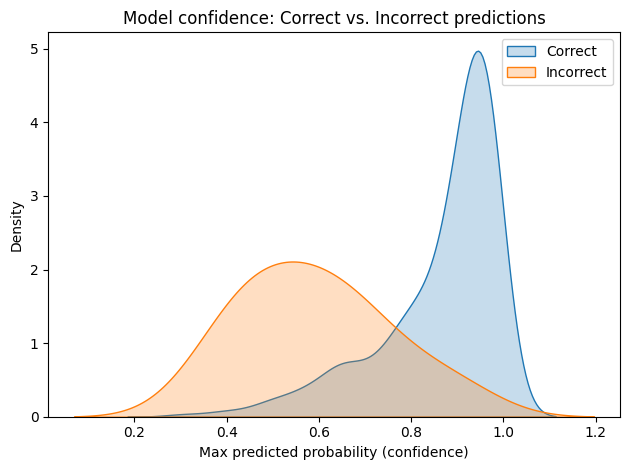

In [43]:
correct_vs_incorrect(y_test_pred_prob, y_test_pred, y_test)